In [1]:
# import all the necessary libraries
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit  
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
from math import sqrt
import statsmodels.formula.api as smf
from scipy.stats import norm
#read the London population flow file 
DF_origin = pd.read_csv('Data/London_flows.csv')

# MLE Calibration Method

In [2]:
def CalculateRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r ** 2
    
    return R2

In [3]:

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

## preprocessing of df

In [4]:
# subset all rows where 'flow' is not zero
DF_origin_drop = DF_origin[DF_origin['flows'] != 0]
DF_origin_drop.sample(5)

,station_origin,station_destination,flows,population,jobs,distance
1653,Archway,Wanstead,1,5642,419,20721.494857
32881,London Bridge,Wood Lane,1,32597,1578,11923.319300
3969,Bayswater,Victoria,47,1571,33251,5806.127427
47333,Southfields,Bounds Green,1,5219,778,23755.866295
14249,Dollis Hill,Tottenham Hale,1,2542,3239,16622.350387


In [5]:
DF_origin_drop['flow'] = DF_origin_drop['flows']
DF_origin_drop['log_flow'] = np.log(DF_origin_drop['flow'])
DF_origin_drop['dist'] = DF_origin_drop['distance'] + 1e-6 + 1
DF_origin_drop['log_dist'] = np.log(DF_origin_drop['dist'])
DF_origin_drop['log_jobs'] = np.log(DF_origin_drop['jobs'])
df_origin = DF_origin_drop.copy()

C:\Users\SBH\AppData\Local\Temp\ipykernel_31816\1392458429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_origin_drop['flow'] = DF_origin_drop['flows']
C:\Users\SBH\AppData\Local\Temp\ipykernel_31816\1392458429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_origin_drop['log_flow'] = np.log(DF_origin_drop['flow'])
C:\Users\SBH\AppData\Local\Temp\ipykernel_31816\1392458429.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [6]:
df_origin.sample(5)

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs
55849,Warwick Avenue,Mile End,4,2388,3759,12741.276720,4,1.386294,12742.276721,9.452681,8.231908
31602,Leicester Square,Oval,25,985,2544,4247.190170,25,3.218876,4248.190171,8.354248,7.841493
36535,North Greenwich,St. James's Park,106,10931,13339,10674.878407,106,4.663439,10675.878408,9.275742,9.498447
48695,St. Paul's,Piccadilly Circus,14,878,13641,3033.798185,14,2.639057,3034.798186,8.017900,9.520835
10436,Chancery Lane,Regent's Park,2,1148,3364,3214.898304,2,0.693147,3215.898305,8.075862,8.120886


In [7]:
#print the describe of each columne
print(df_origin['flows'].describe())
print(df_origin['log_flow'].describe())
# calculate the variance of the flows
print("variance of flows: ", df_origin['flows'].var())
print("variance of log_flow: ", df_origin['log_flow'].var())

count    43952.000000
mean        35.092624
std        154.287205
min          1.000000
25%          2.000000
50%          6.000000
75%         23.000000
max      15946.000000
Name: flows, dtype: float64
count    43952.000000
mean         2.027877
std          1.597166
min          0.000000
25%          0.693147
50%          1.791759
75%          3.135494
max          9.676963
Name: log_flow, dtype: float64
variance of flows:  23804.54155602471
variance of log_flow:  2.550938098313078


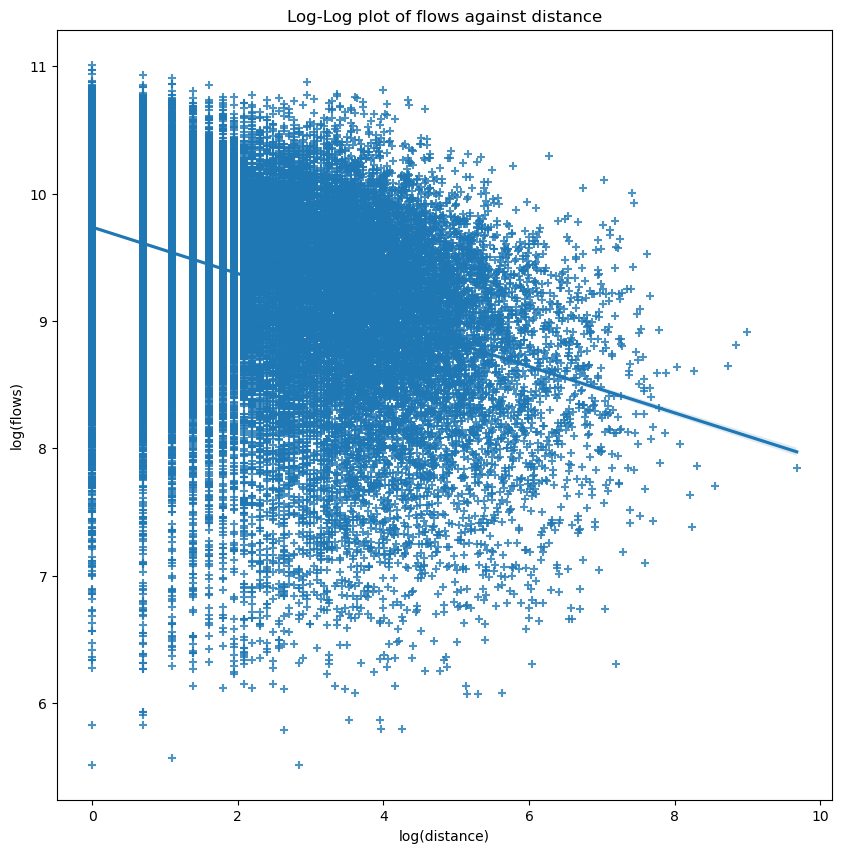

In [8]:
#subset the dataframe to the flows we want
cdata_flows = df_origin[["flows", "distance"]]
#remove all 0 values (logarithms can't deal with 0 values)
cdata_flows = cdata_flows[(cdata_flows!=0).all(1)]

#extract the x and y converting to log
x = np.log(cdata_flows["flows"])
y = np.log(cdata_flows["distance"])

#create the subplot
fig, ax = plt.subplots(figsize = (10,10))
#plot the results along with the line of best fit
sns.regplot(x=x, y=y, marker="+", ax=ax)
# set the title
ax.set_title("Log-Log plot of flows against distance")
ax.set_xlabel("log(distance)")
ax.set_ylabel("log(flows)")
plt.savefig('Images/Poisson_Flow_Distance.png')
plt.show()

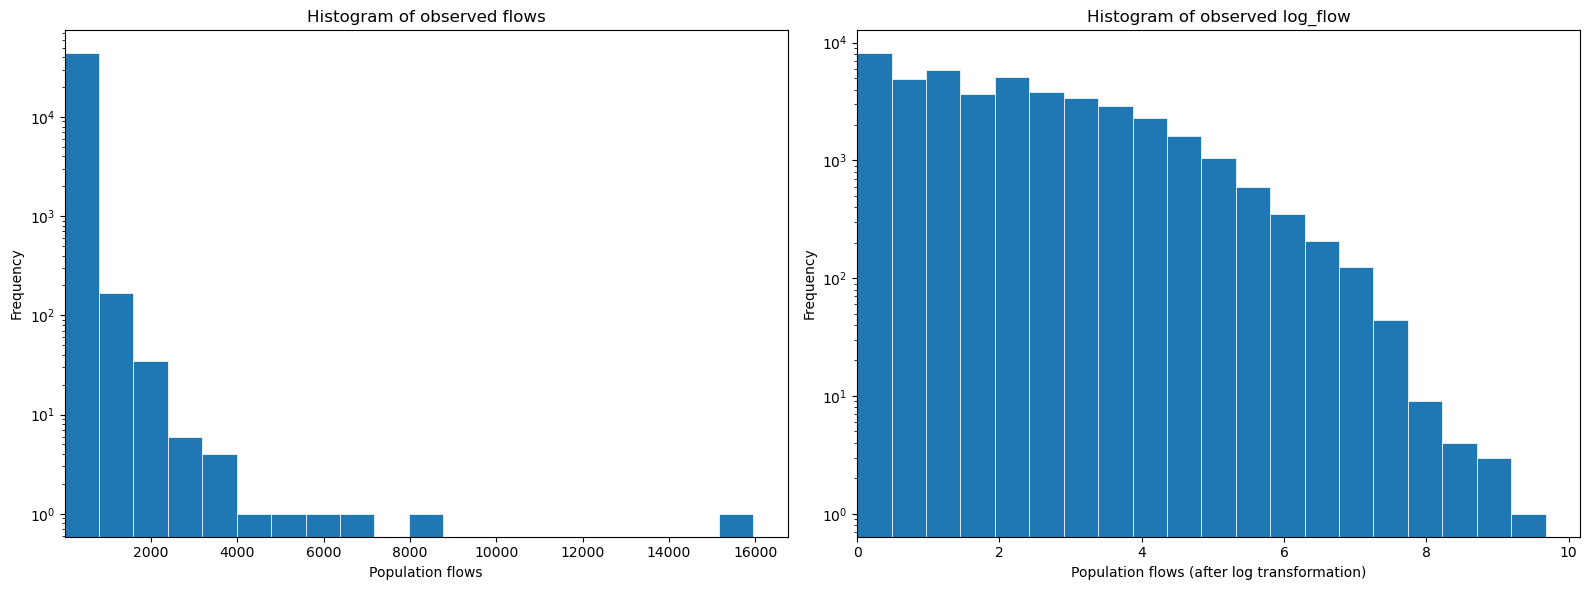

In [9]:
# 创建一个1x2的子图布局

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))  # 1行2列的子图，整体图形大小为16x6

# 第一个子图
axes[0].hist(df_origin['flows'], bins=20, edgecolor='white', linewidth=0.5)
axes[0].set_title('Histogram of observed flows')
axes[0].set_yscale('log')
axes[0].set_xlabel('Population flows')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(left=1)  # 设置x轴最小值为1

# 第二个子图
axes[1].hist(df_origin['log_flow'], bins=20, edgecolor='white', linewidth=0.5)
axes[1].set_title('Histogram of observed log_flow')
axes[1].set_yscale('log')
axes[1].set_xlabel('Population flows (after log transformation)')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(left=0)  # 设置x轴最小值为0

# 显示整个图形
plt.tight_layout()  # 调整子图，避免重叠
plt.savefig('Images/HistogramOfFlows.png')
plt.show()

In [10]:
df_submat_flows = pd.pivot_table(df_origin, index='station_origin', columns='station_destination', values='flows', aggfunc=np.sum, margins=True)
df_submat_logflows = pd.pivot_table(df_origin, index='station_origin', columns='station_destination', values='log_flow', aggfunc=np.sum, margins=True)
df_submat_flows

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,NaN,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,3745
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2886
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,24.0,NaN,NaN,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,NaN,NaN,NaN,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093


- power decay

In [11]:
formula_negbin_pow = "flow ~ station_origin + log_jobs + np.log(dist)-1"

# 使用负二项分布进行拟合
negbin_pow = smf.glm(formula=formula_negbin_pow, data=df_origin, family=sm.families.NegativeBinomial()).fit()
print("R-squared: ", CalculateRSquared(df_origin["flow"], negbin_pow.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], negbin_pow.mu))

c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared:  4.967633589496989e-08
RMSE:  91504.931


In [12]:
formula_negbin_pow = "flow ~ station_origin + log_jobs + np.log(log_dist)-1"

# 使用负二项分布进行拟合
negbin_pow = smf.glm(formula=formula_negbin_pow, data=df_origin, family=sm.families.NegativeBinomial()).fit()
print("R-squared: ", CalculateRSquared(df_origin["flow"], negbin_pow.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], negbin_pow.mu))
print("Alpha: ", negbin_pow.params[0])
print("Gamma: ", negbin_pow.params[1])
print("Beta: ", negbin_pow.params[2])

c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared:  7.130452128020806e-07
RMSE:  2.917569774359751e+67
Alpha:  17.75226573799411
Gamma:  19.728584415370193
Beta:  19.222144126570072


- exponential decay

In [13]:
formula_negbin_exp = "flow ~ station_origin + log_jobs + dist-1"

# 使用负二项分布进行拟合
negbin_exp = smf.glm(formula=formula_negbin_exp, data=df_origin, family=sm.families.NegativeBinomial()).fit()
print("R-squared: ", CalculateRSquared(df_origin["flow"], negbin_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], negbin_exp.mu))

c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared:  0.379477807928869
RMSE:  125.374


In [14]:
formula_negbin_exp = "flow ~ station_origin + log_jobs + log_dist-1"

# 使用负二项分布进行拟合
negbin_exp = smf.glm(formula=formula_negbin_exp, data=df_origin, family=sm.families.NegativeBinomial()).fit()
print("R-squared: ", CalculateRSquared(df_origin["flow"], negbin_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], negbin_exp.mu))

c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared:  4.967633589496989e-08
RMSE:  91504.931


- power decay

In [15]:
# doubly-constrained model with powerlaw distance decay
formula_double_sim_pow = "flow ~ station_origin + log_jobs + np.log(dist)-1"

double_sim_pow = smf.glm(formula=formula_double_sim_pow, data=df_origin, family=sm.families.Poisson()).fit()


print("R-squared: ", CalculateRSquared(df_origin["flow"], double_sim_pow.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], double_sim_pow.mu))

R-squared:  0.16837793721239716
RMSE:  152.287


In [16]:
# doubly-constrained model with powerlaw distance decay
formula_double_sim_pow = "flow ~ station_origin + log_jobs + np.log(log_dist)-1"

double_sim_pow = smf.glm(formula=formula_double_sim_pow, data=df_origin, family=sm.families.Poisson()).fit()


print("R-squared: ", CalculateRSquared(df_origin["flow"], double_sim_pow.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], double_sim_pow.mu))

R-squared:  0.3803910624455263
RMSE:  122.17


- exponential decay

In [17]:
# doubly-constrained model with exponential distance decay
best2_formula_double_sim_exp = "flow ~ station_origin + log_jobs + dist-1"

best2_double_sim_exp = smf.glm(formula=best2_formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()


print("R-squared: ", CalculateRSquared(df_origin["flow"], best2_double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], best2_double_sim_exp.mu))

R-squared:  0.4559048891408868
RMSE:  114.37


In [18]:
# doubly-constrained model with exponential distance decay
formula_double_sim_exp = "flow ~ station_origin + log_jobs + log_dist-1"

double_sim_exp = smf.glm(formula=formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

# print 模型的R方，RMSE， 和倒数三个parameters
print("R-squared: ", CalculateRSquared(df_origin["flow"], double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], double_sim_exp.mu))

R-squared:  0.16837793721239716
RMSE:  152.287


### logged flow

- NegativeBinomial-power decay

In [19]:
formula_negbin_pow = "log_flow ~ station_origin + log_jobs + np.log(dist)-1"

# 使用负二项分布进行拟合
negbin_pow = smf.glm(formula=formula_negbin_pow, data=df_origin, family=sm.families.NegativeBinomial()).fit()
print("R-squared: ", CalculateRSquared(df_origin["log_flow"], negbin_pow.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], negbin_pow.mu))

c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared:  0.019651330896764217
RMSE:  7.201


In [20]:
formula_negbin_pow = "log_flow ~ station_origin + log_jobs + np.log(log_dist)-1"

# 使用负二项分布进行拟合
negbin_pow = smf.glm(formula=formula_negbin_pow, data=df_origin, family=sm.families.NegativeBinomial()).fit()
print("R-squared: ", CalculateRSquared(df_origin["log_flow"], negbin_pow.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], negbin_pow.mu))

c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared:  2.329694809054415e-06
RMSE:  1.536037057167725e+24


- NegativeBinomial-exponential decay

In [21]:
formula_negbin_exp = "log_flow ~ station_origin + log_jobs + dist-1"

# 使用负二项分布进行拟合
negbin_exp = smf.glm(formula=formula_negbin_exp, data=df_origin, family=sm.families.NegativeBinomial()).fit()
print("R-squared: ", CalculateRSquared(df_origin["log_flow"], negbin_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], negbin_exp.mu))

c:\Users\SBH\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared:  0.5117493634142563
RMSE:  1.158


- Poisson-power decay

In [22]:
# doubly-constrained model with powerlaw distance decay
formula_double_sim_pow = "log_flow ~ station_origin + log_jobs + np.log(dist)-1"

double_sim_pow = smf.glm(formula=formula_double_sim_pow, data=df_origin, family=sm.families.Poisson()).fit()


print("R-squared: ", CalculateRSquared(df_origin["log_flow"], double_sim_pow.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], double_sim_pow.mu))

R-squared:  0.30449397993579624
RMSE:  1.44


In [23]:
# doubly-constrained model with powerlaw distance decay
formula_double_sim_pow = "log_flow ~ station_origin + log_jobs + np.log(log_dist)-1"

double_sim_pow = smf.glm(formula=formula_double_sim_pow, data=df_origin, family=sm.families.Poisson()).fit()


print("R-squared: ", CalculateRSquared(df_origin["log_flow"], double_sim_pow.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], double_sim_pow.mu))

R-squared:  0.3935785703510396
RMSE:  1.245


- exponential decay

In [24]:
# doubly-constrained model with exponential distance decay
best_formula_double_sim_exp = "log_flow ~ station_origin + log_jobs + dist-1"

best_double_sim_exp = smf.glm(formula=best_formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

# print 模型的R方，RMSE， 和倒数三个parameters
print("R-squared: ", CalculateRSquared(df_origin["log_flow"], best_double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], best_double_sim_exp.mu))

R-squared:  0.5387247573434126
RMSE:  1.088


In [25]:
# doubly-constrained model with exponential distance decay
formula_double_sim_exp = "log_flow ~ station_origin + log_jobs + log_dist-1"

double_sim_exp = smf.glm(formula=formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

# print 模型的R方，RMSE， 和倒数三个parameters
print("R-squared: ", CalculateRSquared(df_origin["log_flow"], double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], double_sim_exp.mu))

R-squared:  0.30449397993579624
RMSE:  1.44


## scenario-A

### flow without logged

In [26]:
# save all parameters of the model best_double_sim_exp to a dict
params = best2_double_sim_exp.params
params_dict = dict(params)

In [27]:
alpha_i = best2_double_sim_exp.params[0:-2]
gamma = best2_double_sim_exp.params[-2]
beta = -best2_double_sim_exp.params[-1]

In [28]:
beta

0.00014293919318599608

In [29]:
df_origin[df_origin['station_destination'] == 'Canary Wharf']['jobs'].unique()

array([58772], dtype=int64)

In [30]:
SceneA_df = df_origin.copy()
SceneA_df['SceneA_jobs'] = SceneA_df['jobs']
SceneA_df.loc[SceneA_df['station_destination'] == 'Canary Wharf', 'SceneA_jobs'] = 29386
SceneA_df['log_SceneA_jobs'] = np.log(SceneA_df['SceneA_jobs'])
SceneA_df.sample(5)

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs,SceneA_jobs,log_SceneA_jobs
50352,Sudbury Hill,Camden Town,3,1337,6348,23432.024766,3,1.098612,23433.024767,10.061902,8.755895,6348,8.755895
38296,Old Street,Edgware Road,22,5364,6868,6222.072192,22,3.091042,6223.072193,8.736019,8.834628,6868,8.834628
1865,Arnos Grove,Westbourne Park,3,3046,1347,17534.169400,3,1.098612,17535.169401,9.771964,7.205635,1347,7.205635
57634,West Ham,Loughton,7,8879,655,14323.706020,7,1.945910,14324.706021,9.569741,6.484635,655,6.484635
11296,Chorleywood,Northwick Park,2,900,1713,17712.705278,2,0.693147,17713.705279,9.782094,7.446001,1713,7.446001


**recomputing the prediected flow matrix in scenario A**

In [31]:
coefs = pd.DataFrame(alpha_i)
coefs.reset_index(inplace=True)
coefs

,index,0
0,station_origin[Abbey Road],-2.483272
1,station_origin[Acton Central],-0.796531
2,station_origin[Acton Town],-1.390252
3,station_origin[Aldgate],-2.515404
4,station_origin[Aldgate East],-2.524745
...,...,...
393,station_origin[Wood Street],-0.180497
394,station_origin[Woodford],-0.465537
395,station_origin[Woodgrange Park],-0.588263
396,station_origin[Woodside Park],-0.996752


In [32]:
coefs = pd.DataFrame(best2_double_sim_exp.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
coefs
SceneA_df = SceneA_df.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
SceneA_df.drop(columns = ["coef"], inplace = True)
SceneA_df.sample(5)

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs,SceneA_jobs,log_SceneA_jobs,alpha_i
10662,Ealing Common,Regent's Park,2,2003,3364,13919.558473,2,0.693147,13920.558474,9.541122,8.120886,3364,8.120886,-1.900529
7986,Chigwell,Waterloo,6,471,23466,22145.120652,6,1.791759,22146.120653,10.005418,10.063308,23466,10.063308,-2.056118
27264,Oakwood,Pimlico,9,1772,5585,21341.861851,9,2.197225,21342.861852,9.968473,8.627840,5585,8.627840,-1.209040
7703,Charing Cross,Highgate,21,6491,856,8771.168138,21,3.044522,8772.168139,9.079339,6.752270,856,6.752270,-2.008933
35653,Stratford,Crouch Hill,1,59311,404,15086.637893,1,0.000000,15087.637894,9.621631,6.001415,404,6.001415,0.780403


In [33]:
coefs[coefs['coef']=='Dagenham East']

,coef,alpha_i
88,Dagenham East,-0.920887


In [34]:
SceneA_df["SceneA_new_flow"] = np.exp(SceneA_df["alpha_i"] + gamma*SceneA_df["log_jobs"] 
                                 - beta*SceneA_df["dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)


In [35]:
predicted_matrix = SceneA_df.pivot_table(values ="SceneA_new_flow", index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
# round the matrix to 0 decimal places
predicted_matrix = predicted_matrix.round(0)
predicted_matrix

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,15.0,14.0,NaN,15.0,NaN,NaN,18.0,...,15.0,3.0,2.0,21.0,NaN,NaN,NaN,NaN,NaN,3745.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,2886.0
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,32.0,...,3.0,NaN,NaN,3.0,NaN,1.0,NaN,1.0,NaN,3172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,43.0,54.0,NaN,NaN,NaN,NaN,33.0,...,3.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,4868.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,2.0,20.0,20.0,NaN,NaN,NaN,NaN,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [36]:
# get the observed matrix from df_origin
observed_matrix = pd.pivot_table(SceneA_df, index='station_origin', columns='station_destination', values='flow', aggfunc=np.sum, margins=True)
observed_matrix = observed_matrix.round(0)
observed_matrix

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,NaN,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,3745
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2886
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,24.0,NaN,NaN,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,NaN,NaN,NaN,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093


### flow with logged

this model have the better performance than the model without logged, but it is not able to calculate the original flow matrix, only the logged-flow matrix, however, the observed one and predicted one can still be compared.

In [37]:
# save all parameters of the model best_double_sim_exp to a dict
params = best_double_sim_exp.params
params_dict = dict(params)
alpha_i = best_double_sim_exp.params[0:-2]
gamma = best_double_sim_exp.params[-2]
beta = -best_double_sim_exp.params[-1]
SceneA2_df = df_origin.copy()
SceneA2_df['SceneA_jobs'] = SceneA2_df['jobs']
SceneA2_df.loc[SceneA2_df['station_destination'] == 'Canary Wharf', 'SceneA_jobs'] = 29386
SceneA2_df['log_SceneA_jobs'] = np.log(SceneA2_df['SceneA_jobs'])
SceneA2_df.sample(5)

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs,SceneA_jobs,log_SceneA_jobs
52361,Totteridge & Whetstone,Harrow-on-the-Hill,1,2301,3019,32386.490579,1,0.000000,32387.490580,10.385528,8.012681,3019,8.012681
54351,Uxbridge,Sudbury Hill,10,2764,277,11969.989080,10,2.302585,11970.989081,9.390241,5.624018,277,5.624018
3484,Barkingside,Kentish Town,2,1301,3404,25089.798597,2,0.693147,25090.798598,10.130256,8.132706,3404,8.132706
19734,Gloucester Road,Bromley-by-Bow,2,4779,1613,14207.121403,2,0.693147,14208.121404,9.561569,7.385851,1613,7.385851
8671,Canada Water,Moor Park,1,27026,550,33969.120537,1,0.000000,33970.120538,10.433237,6.309918,550,6.309918


In [38]:
coefs = pd.DataFrame(alpha_i)
coefs.reset_index(inplace=True)

coefs = pd.DataFrame(best2_double_sim_exp.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)

SceneA2_df = SceneA2_df.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
SceneA2_df.drop(columns = ["coef"], inplace = True)
SceneA2_df.sample(5)

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs,SceneA_jobs,log_SceneA_jobs,alpha_i
18238,Highbury & Islington,Fulham Broadway,32,23714,4200,11987.968776,32,3.465736,11988.968777,9.391742,8.342840,4200,8.342840,-0.373809
1376,Arsenal,Great Portland Street,28,2158,6936,4976.145842,28,3.332205,4977.145843,8.512612,8.844481,6936,8.844481,-2.620071
27529,Osterley,Edgware Road,5,1421,6868,17135.106168,5,1.609438,17136.106169,9.748943,8.834628,6868,8.834628,-1.543046
14720,Golders Green,Ladbroke Grove,2,4792,2131,14854.946255,2,0.693147,14855.946256,9.606155,7.664347,2131,7.664347,-1.269915
2814,Bayswater,Pimlico,4,1571,5585,7206.005577,4,1.386294,7207.005578,8.882809,8.627840,5585,8.627840,-2.728154


In [39]:
# calculate the predicted flow values
SceneA2_df["SceneA_new_logged_flow"] = np.exp(SceneA2_df["alpha_i"] + gamma*SceneA2_df["log_jobs"] 
                                 - beta*SceneA2_df["dist"])
matrix3= SceneA2_df.pivot_table(values ="SceneA_new_logged_flow", index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
# round the matrix to 0 decimal places
matrix3 = matrix3.round(0)
matrix3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,14.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0
Acton Town,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,185.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,62.0
Aldgate East,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,3.0,3.0,NaN,NaN,NaN,NaN,2.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,336.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0
Woodside Park,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190.0


In [40]:
# get the observed matrix from df_origin
observed_matrix_log = pd.pivot_table(SceneA2_df, index='station_origin', columns='station_destination', values='log_flow', aggfunc=np.sum, margins=True)
observed_matrix_log = observed_matrix_log.round(0)
observed_matrix_log

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,43.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0
Acton Town,NaN,NaN,NaN,1.0,3.0,NaN,4.0,NaN,NaN,2.0,...,4.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,363.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,182.0
Aldgate East,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,3.0,NaN,NaN,2.0,NaN,0.0,NaN,0.0,NaN,305.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,2.0,4.0,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,342.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0
Woodside Park,NaN,NaN,0.0,3.0,2.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289.0


## Plotting for A

In [41]:
# subset the destination columns's last row in the predicted_matrix
predicted_matrix_dest = predicted_matrix.iloc[-1,:-1]
observed_matrix_dest = observed_matrix.iloc[-1,:-1]

In [42]:
# sort the predicted_matrix_dest in descending order
rank_predicted_matrix_dest = predicted_matrix_dest.sort_values(ascending=False).tolist()
rank_observed_matrix_dest = observed_matrix_dest.sort_values(ascending=False).tolist()

In [43]:
# log the predicted_matrix_dest and observed_matrix_dest
log_rank_predicted_matrix_dest = np.log(rank_predicted_matrix_dest)
log_rank_observed_matrix_dest = np.log(rank_observed_matrix_dest)

In [44]:
predict_vs_observed = pd.DataFrame({"Predicted": log_rank_predicted_matrix_dest, "Observed": log_rank_observed_matrix_dest})
predict_vs_observed

,Predicted,Observed
0,11.113924,11.271478
1,11.010283,11.020627
2,10.988018,10.981421
3,10.756838,10.932285
4,10.587216,10.700274
...,...,...
393,4.219508,4.510860
394,4.219508,4.477337
395,4.204693,4.430817
396,4.127134,4.330733


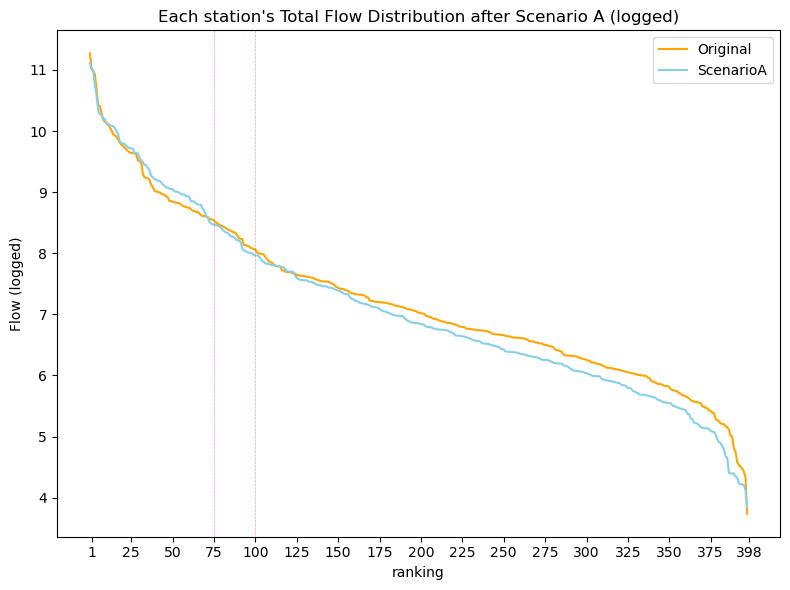

In [45]:
import matplotlib.pyplot as plt

# 为了创建折线图，我们需要获取每个站点的名称作为 x 轴的标签
stations = predict_vs_observed.index

# 创建一个折线图，将预测值和观测值作为两组不同颜色的线
fig, ax = plt.subplots(figsize=(8, 6))  # 设置图的大小

# 绘制折线图
ax.plot(stations, predict_vs_observed['Observed'], label='Original', color='orange')
ax.plot(stations, predict_vs_observed['Predicted'], label='ScenarioA', color='skyblue')

# 添加标题和坐标轴标签
ax.set_title("Each station's Total Flow Distribution after Scenario A (logged)")
ax.set_xlabel('ranking')
ax.set_ylabel('Flow (logged)')


# 添加图例
ax.legend()
plt.xticks([1,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,398])

# 添加辅助线x=75
plt.axvline(x=75, color='r', linestyle='--', linewidth=0.5, alpha=0.4)
plt.axvline(x=100, color='r', linestyle='--', linewidth=0.5, alpha=0.4)

# 显示图表
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.savefig('Images/ScenarioA.png')
plt.show()


## plotting for B

In [46]:
params = best2_double_sim_exp.params
params_dict = dict(params)
alpha_i = best2_double_sim_exp.params[0:-2]
gamma = best2_double_sim_exp.params[-2]
beta = -best2_double_sim_exp.params[-1]

In [47]:
# increase beta , which means the distance cost function is higher
# ln(10/9) equals to 0.105
# ln(10/8) equals to 0.223
beta_2 = beta * 2
beta_3 = beta * 1.5
print(beta_2,beta_3)

0.00028587838637199217 0.00021440878977899413


In [48]:
SceneB1_df = df_origin.copy()

In [49]:
coefs = pd.DataFrame(alpha_i)
coefs.reset_index(inplace=True)

In [50]:
coefs = pd.DataFrame(best2_double_sim_exp.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
coefs
SceneB1_df = SceneB1_df.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
SceneB1_df.drop(columns = ["coef"], inplace = True)
SceneB1_df.sample(5)

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs,alpha_i
13479,Finchley Central,Cannon Street,3,6268,4698,15115.192171,3,1.098612,15116.192172,9.623522,8.454892,-0.599185
21655,Knightsbridge,Pimlico,1,1125,5585,3973.320848,1,0.000000,3974.320849,8.287609,8.627840,-3.494669
27927,Oxford Circus,Notting Hill Gate,26,2784,5490,3952.851537,26,3.258097,3953.851538,8.282445,8.610684,-2.816027
39035,Vauxhall,North Wembley,1,16218,365,18382.833586,1,0.000000,18383.833587,9.819227,5.899897,-0.734354
1266,Arnos Grove,Plaistow,1,3046,1049,19292.901548,1,0.000000,19293.901549,9.867544,6.955593,-1.246527


In [51]:
SceneB1_df.sample(5)

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs,alpha_i
14822,Goldhawk Road,Gunnersbury,1,1347,4775,4707.064050,1,0.000000,4708.064051,8.457032,8.471149,-2.582690
42376,White City,Caledonian Road,2,2445,1803,11458.751202,2,0.693147,11459.751203,9.346596,7.497207,-2.160802
24945,Morden,Chancery Lane,68,8035,15391,17057.443490,68,4.219508,17058.443491,9.744401,9.641538,-0.075317
11562,East Putney,Moorgate,15,5448,24574,13774.152285,15,2.708050,13775.152286,9.530622,10.109444,-1.227788
4804,Brent Cross,Camden Town,37,1494,6348,7110.696201,37,3.610918,7111.696202,8.869496,8.755895,-2.211053


In [52]:
SceneB1_df["SceneB1_2_new_flow"] = np.exp(SceneB1_df["alpha_i"] + gamma*SceneB1_df["log_jobs"] 
                                 - beta_2*SceneB1_df["dist"])

SceneB1_df["SceneB1_15_new_flow"] = np.exp(SceneB1_df["alpha_i"] + gamma*SceneB1_df["log_jobs"] 
                                 - beta_3*SceneB1_df["dist"])

In [53]:
predicted_2beta_matrix = SceneB1_df.pivot_table(values ="SceneB1_2_new_flow", index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
# round the matrix to 0 decimal places
predicted_2beta_matrix = predicted_2beta_matrix.round(0)

predicted_15beta_matrix = SceneB1_df.pivot_table(values ="SceneB1_15_new_flow", index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
# round the matrix to 0 decimal places
predicted_15beta_matrix = predicted_15beta_matrix.round(0)

In [54]:
predicted_2beta_matrix

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,398.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0
Acton Town,NaN,NaN,NaN,1.0,1.0,NaN,7.0,NaN,NaN,2.0,...,2.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,962.0
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1653.0
Aldgate East,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,...,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,5.0,7.0,NaN,NaN,NaN,NaN,2.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,760.0
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.0
Woodside Park,NaN,NaN,0.0,2.0,2.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,439.0


In [55]:
observed_matrix

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,NaN,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,NaN,NaN,NaN,NaN,3745
Aldgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,NaN,NaN,4.0,8.0,NaN,NaN,NaN,NaN,NaN,2886
Aldgate East,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,...,24.0,NaN,NaN,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,NaN,NaN,NaN,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [56]:
# subset the destination columns's last row in the predicted_matrix
predicted_2beta_matrix_dest = predicted_2beta_matrix.iloc[-1,:-1]
predicted_15beta_matrix_dest = predicted_15beta_matrix.iloc[-1,:-1]
observed_matrix_dest = observed_matrix.iloc[-1,:-1]
# sort the predicted_matrix_dest in descending order
rank_predicted_2beta_matrix_dest = predicted_2beta_matrix_dest.sort_values(ascending=False).tolist()
rank_predicted_15beta_matrix_dest = predicted_15beta_matrix_dest.sort_values(ascending=False).tolist()
rank_observed_matrix_dest = observed_matrix_dest.sort_values(ascending=False).tolist()
# log the predicted_matrix_dest and observed_matrix_dest
log_rank_predicted_2beta_matrix_dest = np.log(rank_predicted_2beta_matrix_dest)
log_rank_predicted_15beta_matrix_dest = np.log(rank_predicted_15beta_matrix_dest)
log_rank_observed_matrix_dest = np.log(rank_observed_matrix_dest)
predict_beta_vs_observed = pd.DataFrame({"Predicted_2beta": log_rank_predicted_2beta_matrix_dest,"Predicted_15beta": log_rank_predicted_15beta_matrix_dest, "Observed": log_rank_observed_matrix_dest})
predict_beta_vs_observed


,Predicted_2beta,Predicted_15beta,Observed
0,10.223830,10.613688,11.271478
1,9.986265,10.442288,11.020627
2,9.937019,10.395497,10.981421
3,9.859118,10.251041,10.932285
4,9.671177,10.076810,10.700274
...,...,...,...
393,3.433987,3.761200,4.510860
394,3.401197,3.688879,4.477337
395,3.332205,3.663562,4.430817
396,3.295837,3.637586,4.330733


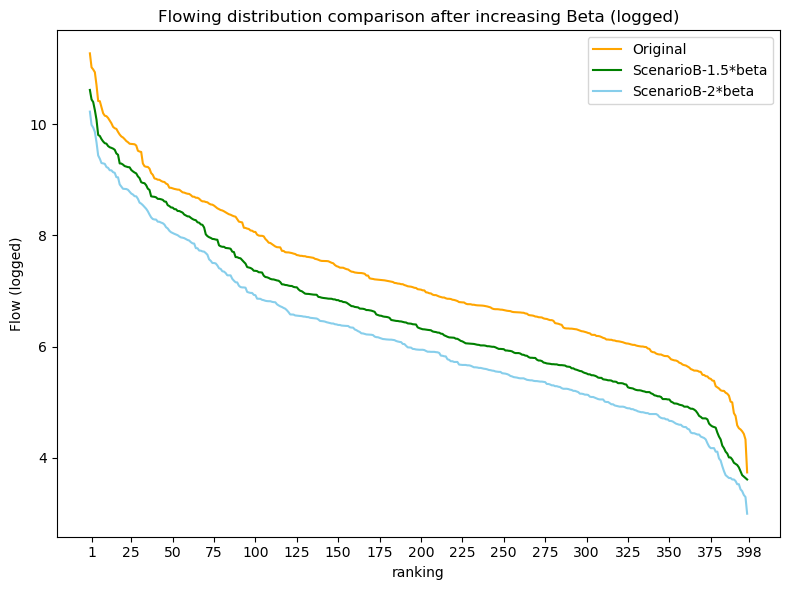

In [57]:
import matplotlib.pyplot as plt

# 为了创建折线图，我们需要获取每个站点的名称作为 x 轴的标签
stations = predict_vs_observed.index

# 创建一个折线图，将预测值和观测值作为两组不同颜色的线
fig, ax = plt.subplots(figsize=(8, 6))  # 设置图的大小

# 绘制折线图
ax.plot(stations, predict_beta_vs_observed['Observed'], label='Original', color='orange')
ax.plot(stations, predict_beta_vs_observed['Predicted_15beta'], label='ScenarioB-1.5*beta', color='green')
ax.plot(stations, predict_beta_vs_observed['Predicted_2beta'], label='ScenarioB-2*beta', color='skyblue')

# 添加标题和坐标轴标签
ax.set_title('Flowing distribution comparison after increasing Beta (logged)')
ax.set_xlabel('ranking')
ax.set_ylabel('Flow (logged)')


# 添加图例
ax.legend()
plt.xticks([1,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,398])

# 显示图表
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.savefig('Images/ScenarioB-beta.png')
plt.show()


### Scenario B-alpha_i

In [58]:
params = best2_double_sim_exp.params
params_dict = dict(params)
alpha_i = best2_double_sim_exp.params[0:-2]
gamma = best2_double_sim_exp.params[-2]
beta = -best2_double_sim_exp.params[-1]

In [59]:
SceneB2_df = SceneB1_df.copy()
SceneB2_df['alpha_09i'] = SceneB2_df['alpha_i'] - 0.105
SceneB2_df['alpha_08i'] = SceneB2_df['alpha_i'] - 0.223

In [60]:
SceneB2_df["SceneB2_09_new_flow"] = np.exp(SceneB2_df["alpha_09i"] + gamma*SceneB2_df["log_jobs"] 
                                 - beta*SceneB1_df["dist"])

SceneB2_df["SceneB2_08_new_flow"] = np.exp(SceneB2_df["alpha_08i"] + gamma*SceneB2_df["log_jobs"] 
                                 - beta*SceneB1_df["dist"])

In [61]:
predicted_09alpha_matrix = SceneB2_df.pivot_table(values ="SceneB2_09_new_flow", index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
# round the matrix to 0 decimal places
predicted_09alpha_matrix = predicted_09alpha_matrix.round(0)

predicted_08alpha_matrix = SceneB2_df.pivot_table(values ="SceneB2_08_new_flow", index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
# round the matrix to 0 decimal places
predicted_08alpha_matrix = predicted_08alpha_matrix.round(0)

In [62]:
# subset the destination columns's last row in the predicted_matrix
predicted_09alpha_matrix_dest = predicted_09alpha_matrix.iloc[-1,:-1]
predicted_08alpha_matrix_dest = predicted_08alpha_matrix.iloc[-1,:-1]
observed_matrix_dest = observed_matrix.iloc[-1,:-1]
# sort the predicted_matrix_dest in descending order
rank_predicted_09alpha_matrix_dest = predicted_09alpha_matrix_dest.sort_values(ascending=False).tolist()
rank_predicted_08alpha_matrix_dest = predicted_08alpha_matrix_dest.sort_values(ascending=False).tolist()
rank_observed_matrix_dest = observed_matrix_dest.sort_values(ascending=False).tolist()
# log the predicted_matrix_dest and observed_matrix_dest
log_rank_predicted_09alpha_matrix_dest = np.log(rank_predicted_09alpha_matrix_dest)
log_rank_predicted_08alpha_matrix_dest = np.log(rank_predicted_08alpha_matrix_dest)
log_rank_observed_matrix_dest = np.log(rank_observed_matrix_dest)
predict_alpha_vs_observed = pd.DataFrame({"Predicted_09alpha": log_rank_predicted_09alpha_matrix_dest,"Predicted_08alpha": log_rank_predicted_08alpha_matrix_dest, "Observed": log_rank_observed_matrix_dest})
predict_alpha_vs_observed

,Predicted_09alpha,Predicted_08alpha,Observed
0,11.008926,10.890926,11.271478
1,10.905295,10.787296,11.020627
2,10.883016,10.765026,10.981421
3,10.651833,10.533855,10.932285
4,10.482205,10.364230,10.700274
...,...,...,...
393,4.110874,3.988984,4.510860
394,4.110874,3.988984,4.477337
395,4.094345,3.970292,4.430817
396,4.025352,3.912023,4.330733


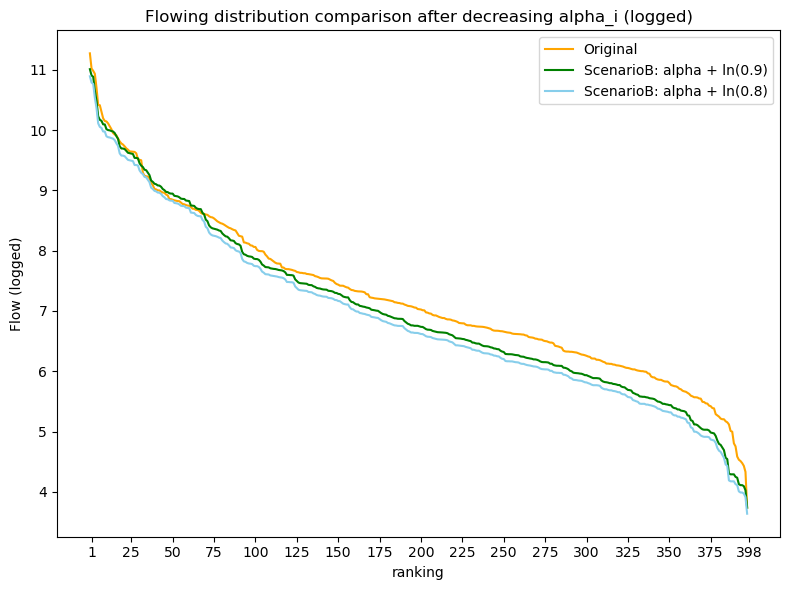

In [63]:
import matplotlib.pyplot as plt



# 创建一个折线图，将预测值和观测值作为两组不同颜色的线
fig, ax = plt.subplots(figsize=(8, 6))  # 设置图的大小

# 绘制折线图
ax.plot(stations, predict_alpha_vs_observed['Observed'], label='Original', color='orange')
ax.plot(stations, predict_alpha_vs_observed['Predicted_09alpha'], label='ScenarioB: alpha + ln(0.9)', color='green')
ax.plot(stations, predict_alpha_vs_observed['Predicted_08alpha'], label='ScenarioB: alpha + ln(0.8)', color='skyblue')


# 添加标题和坐标轴标签
ax.set_title('Flowing distribution comparison after decreasing alpha_i (logged)')
ax.set_xlabel('ranking')
ax.set_ylabel('Flow (logged)')


# 添加图例
ax.legend()
plt.xticks([1,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,398])

# 显示图表
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.savefig('Images/ScenarioB-alpha.png')
plt.show()


ValueError: '..' is not a valid value for ls; supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

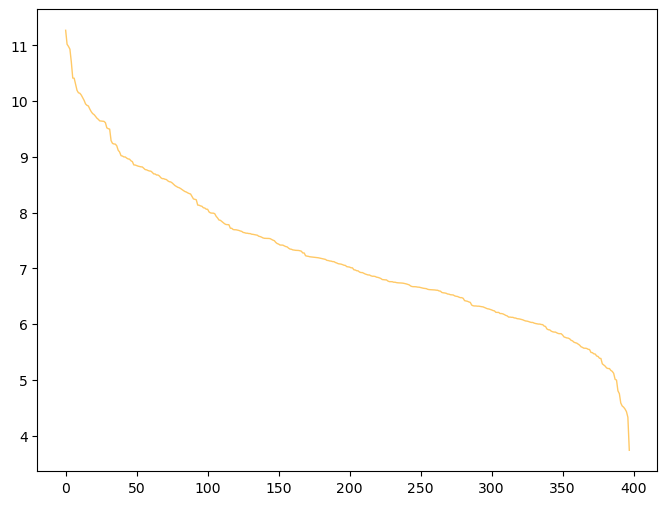

In [64]:
# 创建一个折线图，将预测值和观测值作为两组不同颜色的线
fig, ax = plt.subplots(figsize=(8, 6))  # 设置图的大小

# 绘制折线图
ax.plot(stations, predict_alpha_vs_observed['Observed'], label='Original', color='orange', linestyle='-', linewidth=1, alpha=0.6)
ax.plot(stations, predict_vs_observed['Predicted'], label='ScenarioA', color='red', linestyle='..', linewidth=1, alpha=0.6)
ax.plot(stations, predict_beta_vs_observed['Predicted_15beta'], label='ScenarioB-1.5*beta', color='skyblue', linestyle='-.', linewidth=1, alpha=0.6)
ax.plot(stations, predict_beta_vs_observed['Predicted_2beta'], label='ScenarioB-2*beta', color='blue', linestyle='-.', linewidth=1, alpha=0.6)
ax.plot(stations, predict_alpha_vs_observed['Predicted_09alpha'], label='ScenarioB: alpha + ln(0.9)', color='green', linestyle='--', linewidth=1, alpha=0.6)
ax.plot(stations, predict_alpha_vs_observed['Predicted_08alpha'], label='ScenarioB: alpha + ln(0.8)', color='olive', linestyle='--', linewidth=1, alpha=0.6)


# 添加标题和坐标轴标签
ax.set_title('Flowing Re-distribution comparison under various Scenarios (logged)')
ax.set_xlabel('ranking')
ax.set_ylabel('Flow (logged)')


# 添加图例
ax.legend()
plt.xticks([1,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,398])

# 显示图表
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.savefig('Images/Scenarios_Comparison.png')
plt.show()